In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
from PIL import Image
import matplotlib.cm as cm
from pneumoniacnn import PneumoniaCNN
import utils as uti

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Set paths
data_dir = '../data/chest_xray'
test_dir = os.path.join(data_dir, 'test')

# Define transforms
__, test_transform, viz_transform =  uti.transform_imgs()

# Load test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Dataset for visualization (without normalization)
viz_dataset = datasets.ImageFolder(root=test_dir, transform=viz_transform)

# Load the model
model = PneumoniaCNN()
model.to(device)

# Load the saved model
checkpoint = torch.load('cnn/pneumonia_cnn_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
class_names = checkpoint['class_names']
print("Loaded saved model successfully!")

# Set model to evaluation mode
model.eval()

Loaded saved model successfully!


PneumoniaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [3]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        # Forward hook to save activations
        def forward_hook(module, input, output):
            self.activations = output
        
        # Backward hook to save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Get the target layer
        if self.target_layer == 'conv1':
            target_module = self.model.conv1
        elif self.target_layer == 'conv2':
            target_module = self.model.conv2
        elif self.target_layer == 'conv3':
            target_module = self.model.conv3
        elif self.target_layer == 'conv4':
            target_module = self.model.conv4
        else:
            raise ValueError(f"Unknown target layer: {self.target_layer}")
        
        # Register hooks
        self.hooks.append(target_module.register_forward_hook(forward_hook))
        self.hooks.append(target_module.register_full_backward_hook(backward_hook))
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
    
    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.zero_grad()
        output = self.model(x)
        
        # If class_idx is None, use the predicted class
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass (compute gradients)
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)
        
        # Compute Grad-CAM
        with torch.no_grad():
            # Global average pool gradients
            weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
            
            # Weight activations by gradients
            # cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
            cam = torch.abs(torch.sum(weights * self.activations, dim=1, keepdim=True))
            
            # Apply ReLU
            cam = torch.relu(cam)
            
            if torch.sum(cam).item() == 0:
                cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
                print("Using non-ReLU version since ReLU version was all zeros")
            
            # Resize to input size
            cam = torch.nn.functional.interpolate(
                cam, size=(224, 224), mode='bilinear', align_corners=False
            )
            
            # Normalize
            if torch.max(cam) > 0:
                cam = cam / torch.max(cam)
        
        # Return numpy array
        return cam.squeeze().cpu().numpy()

# Function to visualize Grad-CAM
def visualize_gradcam(img_tensor, cam, original_img, title):
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original X-ray')
    axes[0].axis('off')
    
    # Plot Grad-CAM heatmap
    heatmap_img = axes[1].imshow(cam, cmap='hot')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    fig.colorbar(heatmap_img, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot overlay of heatmap on original image
    # Convert original image to RGB for overlay
    if len(original_img.shape) == 2:  # If grayscale
        original_img_rgb = np.stack([original_img] * 3, axis=2)
    else:  # If already RGB
        original_img_rgb = original_img
    
    # Normalize original image if needed
    if original_img_rgb.max() > 1.0:
        original_img_rgb = original_img_rgb / 255.0
    
    # Create heatmap
    heatmap = cm.jet(cam)
    heatmap = heatmap[..., :3]  # Remove alpha channel
    
    # Create overlay with transparency
    alpha = 0.4
    overlay = original_img_rgb * (1 - alpha) + heatmap * alpha
    
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    return fig

# Main function to run Grad-CAM analysis
def analyze_with_gradcam(model, figdir):
    # Get test examples
    normal_indices, pneumonia_indices = uti.get_random_test_examples(test_dataset, n_normal=5, n_pneumonia=5, seed=42)
    # normal_indices, pneumonia_indices = uti.get_test_examples(test_dataset, 5, 5)
    
    # Initialize Grad-CAM with target layer
    grad_cam = GradCAM(model, target_layer='conv4')
    
    try:
        # Process normal examples
        print("Processing normal examples...")
        for i, idx in enumerate(normal_indices):
            print(f"  Processing normal example {i+1}/5")
            
            # Get the image and label
            img_tensor, label = test_dataset[idx]
            img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get original image for visualization
            viz_img_tensor, _ = viz_dataset[idx]
            original_img = viz_img_tensor.permute(1, 2, 0).cpu().numpy()
            
            # If the image is RGB, convert to grayscale for display
            if original_img.shape[2] == 3:
                original_img = np.mean(original_img, axis=2)
            
            # Compute prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                pred_prob = probs[0, pred_class].item()
            
            # Compute Grad-CAM for the predicted class
            cam = grad_cam(img_tensor, pred_class)
            
            # Visualize
            title = f"Normal X-ray #{idx} | Predicted: {class_names[pred_class]} ({pred_prob:.2f})"
            fig = visualize_gradcam(img_tensor, cam, original_img, title)
            
            # Save figure
            plt.savefig(figdir + f'/normal_gradcam_{i+1}.png')
            plt.close(fig)
        
        # Process pneumonia examples
        print("Processing pneumonia examples...")
        for i, idx in enumerate(pneumonia_indices):
            print(f"  Processing pneumonia example {i+1}/5")
            
            # Get the image and label
            img_tensor, label = test_dataset[idx]
            img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get original image for visualization
            viz_img_tensor, _ = viz_dataset[idx]
            original_img = viz_img_tensor.permute(1, 2, 0).cpu().numpy()
            
            # If the image is RGB, convert to grayscale for display
            if original_img.shape[2] == 3:
                original_img = np.mean(original_img, axis=2)
            
            # Compute prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                pred_prob = probs[0, pred_class].item()
            
            # Compute Grad-CAM for the predicted class
            cam = grad_cam(img_tensor, pred_class)
            
            # Visualize
            title = f"Pneumonia X-ray #{idx} | Predicted: {class_names[pred_class]} ({pred_prob:.2f})"
            fig = visualize_gradcam(img_tensor, cam, original_img, title)
            
            # Save figure
            plt.savefig(figdir + f'/pneumonia_gradcam_{i+1}.png')
            plt.close(fig)
        
        # Create a combined visualization of all examples
        print("Creating combined visualization...")
        fig, axes = plt.subplots(2, 5, figsize=(25, 10))
        
        # Function to plot compact Grad-CAM visualization
        def plot_compact(ax, idx, row, col, is_normal=True):
            # Get image tensor
            img_tensor, _ = test_dataset[idx]
            img_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Get original image for visualization
            viz_img_tensor, _ = viz_dataset[idx]
            original_img = viz_img_tensor.permute(1, 2, 0).cpu().numpy()
            
            # If the image is RGB, convert to grayscale for display
            if original_img.shape[2] == 3:
                original_img = np.mean(original_img, axis=2)
            
            # Get prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                pred_prob = probs[0, pred_class].item()
            
            # Compute Grad-CAM for the predicted class
            cam = grad_cam(img_tensor, pred_class)
            
            # Convert original image to RGB for overlay
            if len(original_img.shape) == 2:  # If grayscale
                original_img_rgb = np.stack([original_img] * 3, axis=2)
            else:  # If already RGB
                original_img_rgb = original_img
            
            # Normalize original image if needed
            if original_img_rgb.max() > 1.0:
                original_img_rgb = original_img_rgb / 255.0
            
            # Create heatmap
            heatmap = cm.jet(cam)
            heatmap = heatmap[..., :3]  # Remove alpha channel
            
            # Create overlay with transparency
            alpha = 0.5
            overlay = original_img_rgb * (1 - alpha) + heatmap * alpha
            
            # Plot
            ax.imshow(overlay)
            class_text = "Normal" if is_normal else "Pneumonia"
            ax.set_title(f"{class_text} #{idx} | Pred: {class_names[pred_class]} ({pred_prob:.2f})")
            ax.axis('off')

        # Plot pneumonia examples
        for i, idx in enumerate(pneumonia_indices):
            plot_compact(axes[0, i], idx, 1, i, is_normal=False)
        
        # Plot normal examples
        for i, idx in enumerate(normal_indices):
            plot_compact(axes[1, i], idx, 0, i, is_normal=True)

        plt.suptitle("Grad-CAM Attribution Maps", fontsize=20)
        plt.tight_layout()
        plt.savefig(figdir + '/all_gradcams.png')
        plt.close()
        
        print("Grad-CAM analysis complete. Results saved in 'gradcam_maps' folder.")
        
    finally:
        # Clean up hooks
        grad_cam.remove_hooks()

In [4]:
# Run the analysis
# Create directory for saving figures
figdir = "figs/gradcam_maps"
os.makedirs(figdir, exist_ok=True)
analyze_with_gradcam(model, figdir)

Found 234 normal samples and 390 pneumonia samples
Selected normal indices: [163, 28, 6, 189, 70]
Selected pneumonia indices: [359, 348, 305, 611, 286]
Processing normal examples...
  Processing normal example 1/5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


  Processing normal example 2/5
  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/5
Processing pneumonia examples...
  Processing pneumonia example 1/5
  Processing pneumonia example 2/5
  Processing pneumonia example 3/5
  Processing pneumonia example 4/5
  Processing pneumonia example 5/5
Creating combined visualization...
Grad-CAM analysis complete. Results saved in 'gradcam_maps' folder.


Grad-CAM with randomized model
---

In [5]:
# Load the model
randomized_model = PneumoniaCNN()
randomized_model.to(device)

# Load the saved model
checkpoint = torch.load('cnn/randomized_pneumonia_model.pth', map_location=device)
randomized_model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded saved randomized model successfully!")

# Set model to evaluation mode
randomized_model.eval()

# Create directory for saving figures
figdir = "figs/gradcam_maps_rand"
os.makedirs(figdir, exist_ok=True)
analyze_with_gradcam(randomized_model, figdir)

Loaded saved randomized model successfully!
Found 234 normal samples and 390 pneumonia samples
Selected normal indices: [163, 28, 6, 189, 70]
Selected pneumonia indices: [359, 348, 305, 611, 286]
Processing normal examples...
  Processing normal example 1/5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


  Processing normal example 2/5
  Processing normal example 3/5
  Processing normal example 4/5
  Processing normal example 5/5
Processing pneumonia examples...
  Processing pneumonia example 1/5
  Processing pneumonia example 2/5
  Processing pneumonia example 3/5
  Processing pneumonia example 4/5
  Processing pneumonia example 5/5
Creating combined visualization...
Grad-CAM analysis complete. Results saved in 'gradcam_maps' folder.


Misclassification
---

Found 3 misclassified examples


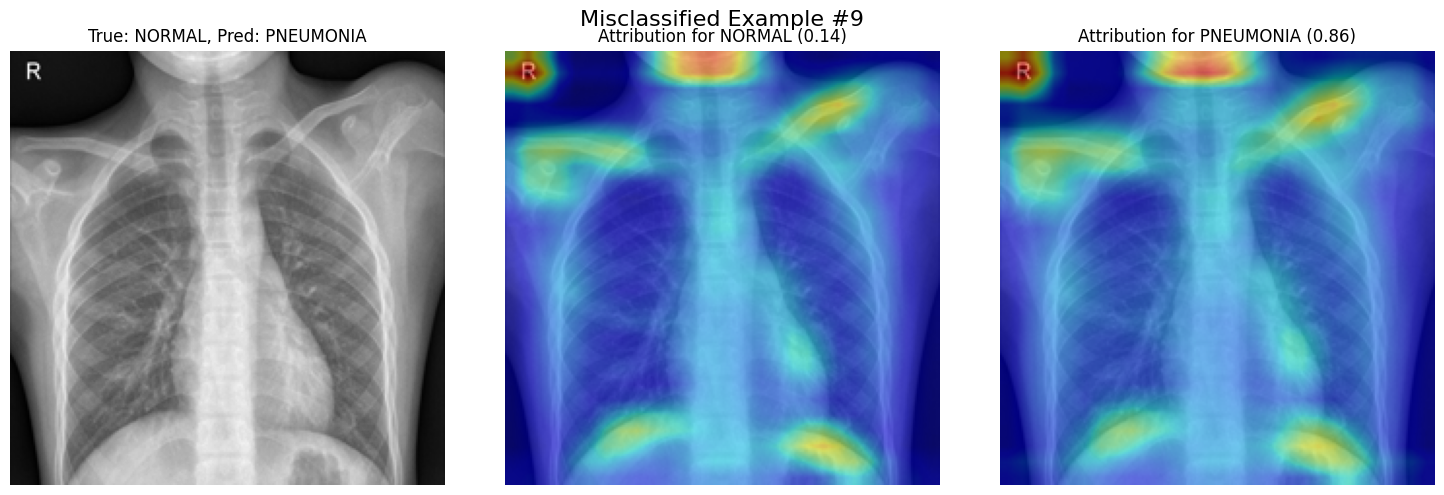

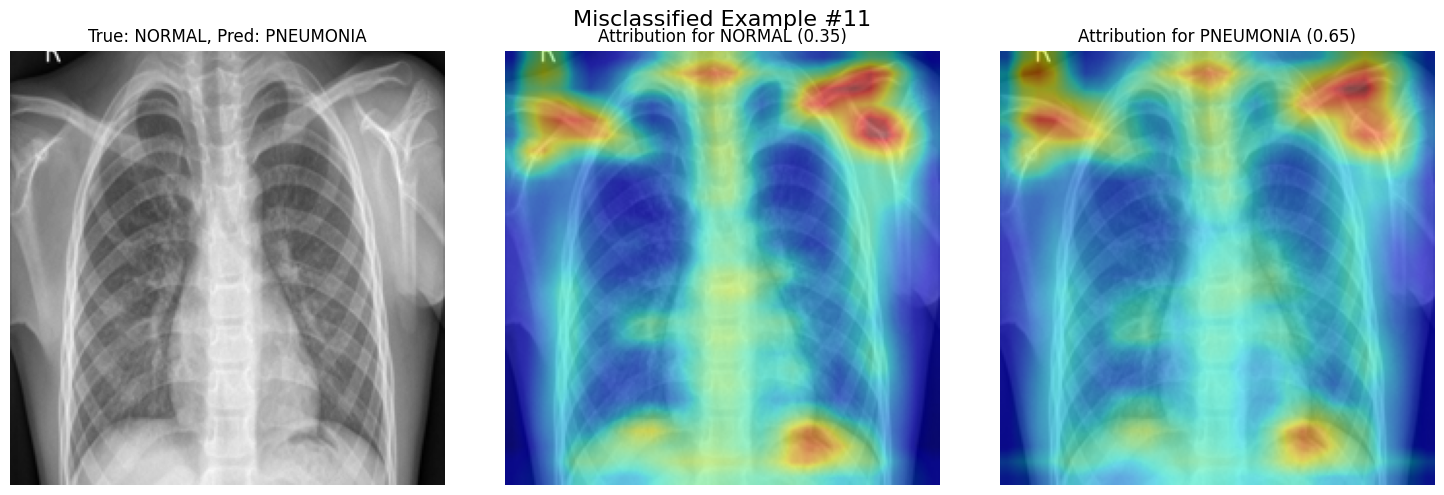

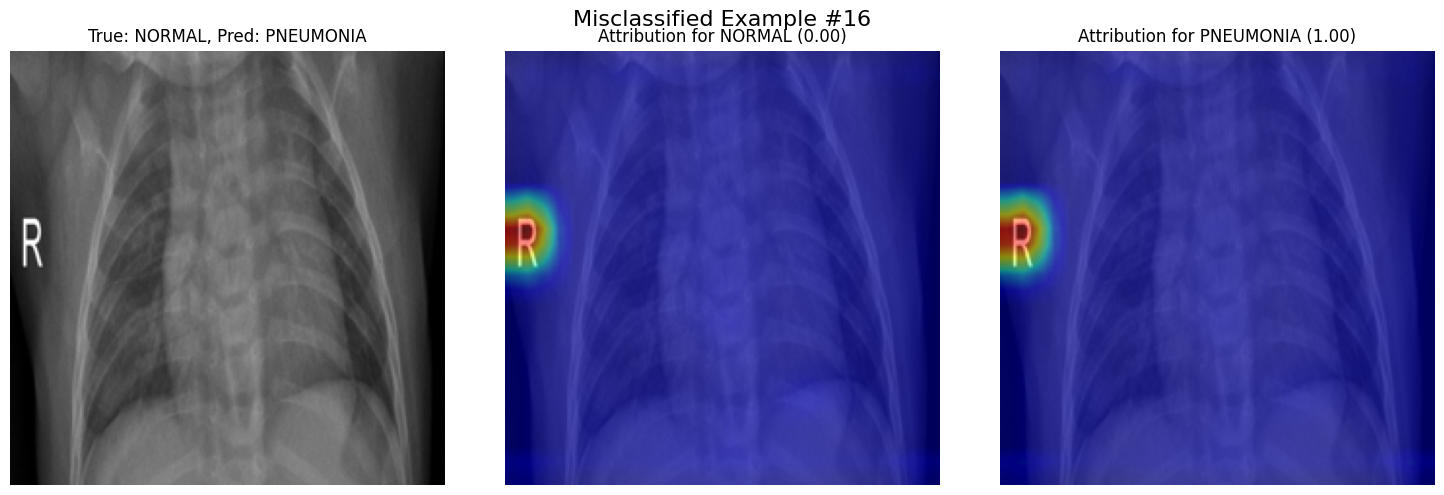

In [6]:
# Additional analysis: Compare attributions for correct and incorrect predictions
def analyze_misclassifications():
    
    grad_cam = GradCAM(model, target_layer='conv4')
    
    # Find some misclassified examples
    misclassified_indices = []
    for i, (img_tensor, label) in enumerate(test_loader):
        img_tensor = img_tensor.to(device)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, preds = torch.max(outputs, 1)
        
        # Check if misclassified
        if preds.item() != label.item() and len(misclassified_indices) < 3:
            misclassified_indices.append(i)
        
        if len(misclassified_indices) >= 3:
            break
    
    # If we found misclassified examples, analyze them
    if misclassified_indices:
        print(f"Found {len(misclassified_indices)} misclassified examples")
        
        for i, idx in enumerate(misclassified_indices):
            # Get the image and label
            img_tensor, label = test_dataset[idx]
            img_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Get the original image for display
            img_path = test_dataset.imgs[idx][0]
            original_img = Image.open(img_path).convert('L')
            original_img = original_img.resize((224, 224))
            original_img_np = np.array(original_img)
            
            # Get prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                pred_prob = probs[0, pred_class].item()
            
            # Create figure to show attributions for both classes
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Plot original image
            axes[0].imshow(original_img_np, cmap='gray')
            axes[0].set_title(f'True: {class_names[label]}, Pred: {class_names[pred_class]}')
            axes[0].axis('off')
            
            # Compute attributions for each class
            for j, class_idx in enumerate([0, 1]):  # 0 for Normal, 1 for Pneumonia
    
                     # Compute Grad-CAM for the predicted class
                cam = grad_cam(img_tensor, class_idx)
                
                # Convert original image to RGB for overlay
                if len(original_img_np.shape) == 2:  # If grayscale
                    original_img_rgb = np.stack([original_img_np] * 3, axis=2)
                else:  # If already RGB
                    original_img_rgb = original_img
                
                # Normalize original image if needed
                if original_img_rgb.max() > 1.0:
                    original_img_rgb = original_img_rgb / 255.0
                
                # Create heatmap
                heatmap = cm.jet(cam)
                heatmap = heatmap[..., :3]  # Remove alpha channel
                
                # Create overlay with transparency
                alpha = 0.5
                overlay = original_img_rgb * (1 - alpha) + heatmap * alpha
                
                # Plot
                axes[j+1].imshow(overlay)
                class_text = class_names[class_idx]
                prob = probs[0, class_idx].item()
                axes[j+1].set_title(f'Attribution for {class_text} ({prob:.2f})')
                axes[j+1].axis('off')
            
            plt.suptitle(f"Misclassified Example #{idx}", fontsize=16)
            plt.tight_layout()
            plt.show()
    else:
        print("No misclassified examples found in the first batch")

# Run misclassification analysis
analyze_misclassifications()